In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# INSERT THE PATH OF THE FOLDER IN WHICH THE FOLLWOING FILES ARE LOCATED:
##### Low-Code.csv / mda.csv / mde.csv / mdd.csv / mba.mcsv / mbe.csv / mdse.csv 
raw_data_folder=""

## Low Code Authors

In [3]:
plt.rcParams.update({'font.size': 20})

In [4]:
df_lowcode = pd.read_csv(raw_data_folder+'Low-Code.csv')

In [5]:
df_lowcode.head(3)

Lens ID                                              Title  \
0  000-070-699-383-125  ECIS - Innovating with employees: an explorato...   
1  000-235-674-128-200  VL/HCC - Bringing visual languages to market: ...   
2  000-269-027-654-007  Artificial Intelligence for Social Good in Res...   

  Date Published  Publication Year        Publication Type  \
0     11/05/2021              2021  conference proceedings   
1            NaN              2018  conference proceedings   
2     19/02/2021              2021  conference proceedings   

                                        Source Title ISSNs Publisher  \
0                                               ECIS   NaN       NaN   
1  IEEE Symposium on Visual Languages and Human-C...   NaN      IEEE   
2         World Conference on Teaching and Education   NaN   ACAVENT   

  Source Country                                       Author/s  ... PMID  \
0            NaN  Désirée Krejci; Satu Iho; Stéphanie Missonier  ...  NaN   
1            NaN                         Rodrigo Sousa Coutinho  ...  NaN   
2            NaN                                 Meng Leong How  ...  NaN   

                                DOI Microsoft Academic ID PMCID  \
0                               NaN          3.176178e+09   NaN   
1        10.1109/vlhcc.2018.8506500          2.898572e+09   NaN   
2  10.33422/2nd.worldcte.2021.01.08          3.202690e+09   NaN   

  Citing Patents Count References Citing Works Count Is Open Access  \
0                    0        NaN                  0          False   
1                    0        NaN                  2          False   
2                    0        NaN                  4           True   

   Open Access License Open Access Colour  
0                  NaN                NaN  
1                  NaN                NaN  
2                  NaN             bronze  

[3 rows x 32 columns]

In [6]:
def add_authors_to_dict(authors, new_authors):
    for a in new_authors:
        if a in authors:
            authors[a] += 1
        else:
            if a != "":
                authors[a] = 1
    return authors

In [7]:
def authors_from_field(df):
    authors = {}
    record_problem = []
    for count, i in enumerate(df['Author/s']):
        authors_paper = []
        try:
            i = i.replace("; ", ";").lower()
            authors_paper = i.split(';')
        except:
            record_problem.append([count])

        authors = add_authors_to_dict(authors, authors_paper)
        
    print('Total Number of authors in the field: ', len(authors))
    return authors, record_problem

In [8]:
authors_lowcode, record_problems = authors_from_field(df_lowcode)

Total Number of authors in the field:  2296


In [9]:
authors_lowcode = dict(sorted(authors_lowcode.items(), key=lambda item: item[1], reverse=True))

## MDA & MDE authors

In [10]:
df_mda = pd.read_csv(raw_data_folder+'mda.csv')

In [11]:
df_mde = pd.read_csv(raw_data_folder+'mde.csv')

In [12]:
df_mba = pd.read_csv(raw_data_folder+'mba.csv')

In [13]:
df_mdd = pd.read_csv(raw_data_folder+'mdd.csv')

In [14]:
df_mdse = pd.read_csv(raw_data_folder+'mdse.csv')

In [15]:
df_mbe = pd.read_csv(raw_data_folder+'mbe.csv')

In [16]:
# Merge DataFrames on the 'key' column
df_model = pd.concat([df_mda,df_mde,df_mba,df_mdd,df_mdse,df_mbe])

# Remove duplicates based on the 'key' column
df_model = df_model.drop_duplicates(subset=['Lens ID'])

# Reset the indices
df_model.reset_index(drop=True, inplace=True)

In [17]:
#active model authors
active_since = 2018
df_model_active = df_model[df_model['Publication Year'] >= active_since]
active_model_authors = authors_from_field(df_model_active)[0]

Total Number of authors in the field:  6139


In [18]:
authors_model, record_problems_model = authors_from_field(df_model)

Total Number of authors in the field:  18473


In [19]:
authors_model_all = dict(sorted(authors_model.items(), key=lambda item: item[1], reverse=True))

In [20]:
#active authors (published from 2018)
authors_model = {key: authors_model_all[key] for key in authors_model_all if key in active_model_authors or key in authors_lowcode} 

## Compare authors from both fields

In [21]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

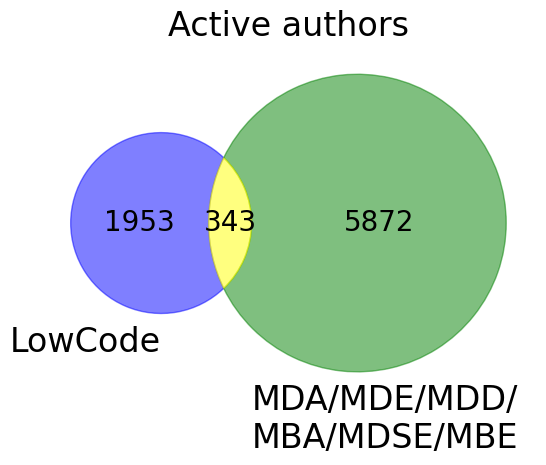

In [22]:
%matplotlib inline
fig = plt.figure()
x = 0
plt.title("Active authors")
recurrent_authors_lowcode = set([a for a in authors_lowcode if authors_lowcode[a] > x])
recurrent_authors_model = set([a for a in authors_model if authors_model[a] > x])

venn = venn2([recurrent_authors_lowcode, recurrent_authors_model], ('LowCode', 'MDA/MDE/MDD/\nMBA/MDSE/MBE'))

# Customize the colors
venn.get_patch_by_id('10').set_color('blue')   # Color for set1 only
venn.get_patch_by_id('01').set_color('#008000') # Color for set2 only
venn.get_patch_by_id('11').set_color('#FFFF00') # Color for intersection

# Customize the alpha (transparency)
venn.get_patch_by_id('10').set_alpha(0.5)
venn.get_patch_by_id('01').set_alpha(0.5)
venn.get_patch_by_id('11').set_alpha(0.5)

# Adjust the position of the 'MDA/MDE/MDD/MBA' label
label = venn.get_label_by_id('B')  # 'B' corresponds to the second set label
label.set_position((label.get_position()[0] - 0.35, label.get_position()[1]))  # Move left by 0.2 units

plt.savefig('active_authors.pdf',bbox_inches='tight')

## Productive authors heatmap

In [23]:
import seaborn as sns
from matplotlib.colors import SymLogNorm
# Function to create heatmap with flexible grid size
def create_heatmap(dict1, dict2, grid_size, quantiles,labels):
    # Combine the dictionaries
    combined_keys = set(dict1.keys()).union(dict2.keys())
    combined_dict = {key: (dict1.get(key, 0), dict2.get(key, 0)) for key in combined_keys}

    # Get values and determine quantiles
    values1 = list(dict1.values())
    values2 = list(dict2.values())

    #quantiles1 = np.quantile(values1, np.linspace(0, 1, grid_size + 1)[1:-1])
    #quantiles2 = np.quantile(values2, np.linspace(0, 1, grid_size + 1)[1:-1])

    quantiles1 = quantiles[0]
    quantiles2 = quantiles[1]
    
    print(quantiles2)

    # Initialize quadrant counts for a grid_size x grid_size grid
    quadrant_counts = np.zeros((grid_size, grid_size))

    # Function to determine the quantile index
    def get_quantile_index(value, quantiles):
        for i, q in enumerate(quantiles):
            if value <= q:
                return i
        return len(quantiles)

    # Categorize and count
    for key, (value1, value2) in combined_dict.items():
        index1 = get_quantile_index(value1, quantiles1)
        index2 = get_quantile_index(value2, quantiles2)
        quadrant_counts[index1, index2] += 1

    # Create the heatmap
    heatmap = sns.heatmap(quadrant_counts, annot=True, fmt='g', cmap='viridis',
                xticklabels=labels[1], 
                yticklabels=labels[0],
                norm=SymLogNorm(linthresh=1, linscale=1, vmin=0, vmax=quadrant_counts.max()))

    # Customize colorbar ticks and labels
    cb = heatmap.collections[0].colorbar
    cb.set_ticks([0, 1, 10, 100, 1000])  # Adjust these ticks as needed
    cb.set_ticklabels(['0', '1', '10', '100', '1000'])  # Adjust these labels as needed

    
    plt.title('Active authors with x publications')
    plt.xlabel('MDA/MDE/MDD/MBA/MDSE/MBE authors')
    plt.ylabel('Low-Code authors')
    plt.xticks(fontsize=18)  # X-axis tick labels font size
    plt.yticks(fontsize=18)  # Y-axis tick labels font size
    plt.savefig('heatmap.pdf', bbox_inches='tight')

[0, 5, 15, 45]


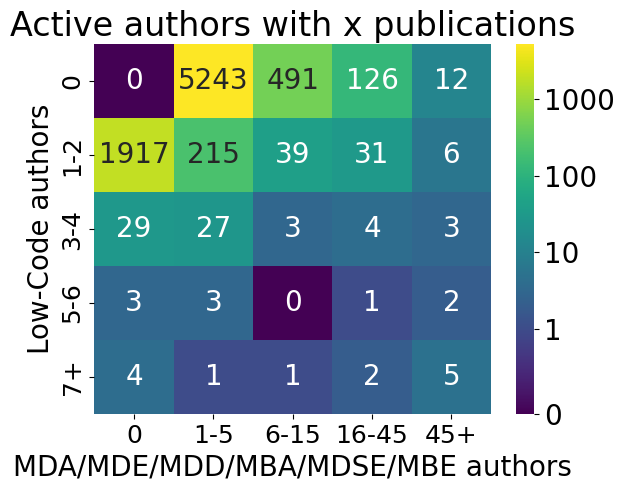

In [24]:
quantiles = [[0,2,4,6], [0,5,15,45]]
labels = [['0', '1-2', '3-4', '5-6', '7+'],['0', '1-5', '6-15', '16-45', '45+']]

# Example usage with a 5x5 grid
create_heatmap(authors_lowcode, authors_model, grid_size=5, quantiles=quantiles, labels=labels)

## Most influential authors in the areas

### Low-Code

In [25]:
def add_citations_to_author(authors, new_author, citations):
    if new_author in authors:
        authors[new_author][0] += citations
        authors[new_author][2].append(citations)
        h_index = 0
        for c in authors[new_author][2]:
            if c > authors[new_author][1]:
                h_index += 1
        if h_index > authors[new_author][1]:
            authors[new_author][1] = h_index
    else:
        authors[new_author] = []
        authors[new_author].append(citations)
        h_index = 1 if citations > 0 else 0
        authors[new_author].append(h_index)
        authors[new_author].append([citations])
    return authors

In [26]:
def authors_citations(df):
    authors = {}
    record_problem = []
    for count, i in enumerate(df['Author/s']):
        authors_paper = []
        try:
            i = i.replace("; ", ";").lower()
            authors_paper = i.split(';')
        except:
            record_problem.append([count])

        citations = df['Citing Works Count'][count]
        
        for author in authors_paper:
            try:
                authors = add_citations_to_author(authors, author, citations)
            except:
                print("bla, ", citations)

    authors = dict(sorted(authors.items(), key=lambda item: (item[1][1], item[1][0]), reverse=True))
         
    print('Total Number of authors in the field: ', len(authors))
    print('Total Number of problems: ', len(record_problem))
    return authors, record_problem

In [27]:
authors_citations_lowcode, problems = authors_citations(df_lowcode)

Total Number of authors in the field:  2296
Total Number of problems:  14


In [28]:
print('author, h_index (within field), total_citations (in field)')
[[k, authors_citations_lowcode[k][1], authors_citations_lowcode[k][0]] for k in list(authors_citations_lowcode)[:20]]

author, h_index (within field), total_citations (in field)


[['davide di ruscio', 6, 222],
 ['alfonso pierantonio', 5, 241],
 ['tiziana margaria', 5, 56],
 ['juan de lara', 4, 90],
 ['manuel wimmer', 4, 89],
 ['dimitris kolovos', 4, 79],
 ['jordi cabot', 3, 138],
 ['massimo tisi', 3, 78],
 ['judith michael', 3, 47],
 ['esther guerra', 3, 36],
 ['hafiz ahmad awais chaudhary', 3, 27],
 ['jobish john', 3, 23],
 ['dirk pesch', 3, 23],
 ['carla ferreira', 3, 20],
 ['simon curty', 3, 15],
 ['felix härer', 3, 15],
 ['hans-georg fill', 3, 15],
 ['yi-bing lin', 3, 13],
 ['apurvanand sahay', 2, 126],
 ['arsene indamutsa', 2, 123]]

### MDA/MDE/MDD/MBA/MBE

In [29]:
authors_citations_models, problems = authors_citations(df_model)

Total Number of authors in the field:  18473
Total Number of problems:  210


In [30]:
print('author, h_index (within field), total_citations (in field)')
[[k, authors_citations_models[k][1], authors_citations_models[k][0]] for k in list(authors_citations_models)[:20]]

author, h_index (within field), total_citations (in field)


[['manuel wimmer', 29, 3562],
 ['jordi cabot', 28, 3378],
 ['jean bézivin', 26, 4091],
 ['frédéric jouault', 24, 2920],
 ['richard f. paige', 24, 2463],
 ['juan de lara', 24, 2342],
 ['esther guerra', 24, 2103],
 ['alfonso pierantonio', 23, 1845],
 ['davide di ruscio', 20, 1683],
 ['mario piattini', 20, 974],
 ['dimitrios s. kolovos', 19, 1910],
 ['marco brambilla', 19, 1817],
 ['juan trujillo', 19, 1448],
 ['jesús sánchez cuadrado', 19, 1148],
 ['massimo tisi', 19, 926],
 ['jean-marc jézéquel', 18, 1260],
 ['dániel varró', 18, 1258],
 ['gerti kappel', 18, 799],
 ['bernhard rumpe', 17, 1739],
 ['ludovico iovino', 17, 805]]

### Intersection of most influential authors on both fields

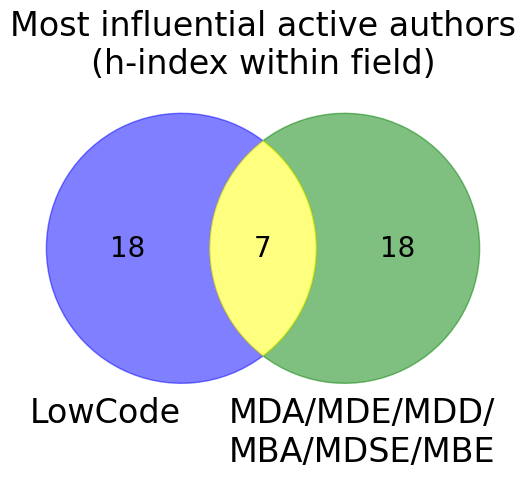

In [31]:
%matplotlib inline
fig = plt.figure()
x = 0
plt.title("Most influential active authors\n(h-index within field)")
lowcode_influence_authors = set([k for k in list(authors_citations_lowcode)[:25]])
models_influence_authors = set([k for k in list(authors_citations_models)[:25]])

venn = venn2([lowcode_influence_authors, models_influence_authors], ('LowCode', 'MDA/MDE/MDD/\nMBA/MDSE/MBE'))

# Customize the colors
venn.get_patch_by_id('10').set_color('blue')   # Color for set1 only
venn.get_patch_by_id('01').set_color('#008000') # Color for set2 only
venn.get_patch_by_id('11').set_color('#FFFF00') # Color for intersection

# Customize the alpha (transparency)
venn.get_patch_by_id('10').set_alpha(0.5)
venn.get_patch_by_id('01').set_alpha(0.5)
venn.get_patch_by_id('11').set_alpha(0.5)

# Adjust the position of the 'MDA/MDE/MDD/MBA' label
label = venn.get_label_by_id('B')  # 'B' corresponds to the second set label
label.set_position((label.get_position()[0] - 0.37, label.get_position()[1]))  # Move left by 0.2 units


plt.savefig('most_influential_authors.pdf', bbox_inches='tight')

In [32]:
#Intersection
lowcode_influence_authors.intersection(models_influence_authors)

{'alfonso pierantonio',
 'davide di ruscio',
 'esther guerra',
 'jordi cabot',
 'juan de lara',
 'manuel wimmer',
 'massimo tisi'}

In [33]:
#Low-Code only
lowcode_influence_authors.difference(models_influence_authors)

{'apurvanand sahay',
 'arsene indamutsa',
 'carla ferreira',
 'dimitris kolovos',
 'dirk pesch',
 'felix härer',
 'gerson sunyé',
 'gias uddin',
 'hafiz ahmad awais chaudhary',
 'hans-georg fill',
 'jean-marie mottu',
 'jobish john',
 'judith michael',
 'robert waszkowski',
 'simon curty',
 'tiziana margaria',
 'ulrich frank',
 'yi-bing lin'}

In [34]:
#MDA/MDE only
models_influence_authors.difference(lowcode_influence_authors)

{'benoit baudry',
 'bernhard rumpe',
 'dimitrios s. kolovos',
 'dániel varró',
 'frédéric jouault',
 'gerti kappel',
 'holger giese',
 'jean bézivin',
 'jean vanderdonckt',
 'jean-marc jézéquel',
 'jesús garcía molina',
 'jesús sánchez cuadrado',
 'juan trujillo',
 'ludovico iovino',
 'marco brambilla',
 'mario piattini',
 'oscar pastor',
 'richard f. paige'}

## Coauthorship network

In [35]:
import copy

In [36]:
def coauthorship_analysis(df, authors):
    authors_position = copy.deepcopy(authors)

    for count, author in enumerate(authors_position):
        authors_position[author] = count
    
    co_authorship = np.zeros((len(authors_position), len(authors_position)))
    record_problem = []
    for count, i in enumerate(df['Author/s']):
        authors_paper = []
        try:
            i = i.replace("; ", ";").lower()
            authors_paper = i.split(';')
        except:
            record_problem.append([count])

        positions = []
        for author in authors_paper:
            if author != "":
                positions.append(authors_position[author])

        if len(positions) != 0:
            for i in range(0,len(positions)):
                for j in range(i,len(positions)):
                    #print(i, j)
                    co_authorship[positions[i]][positions[j]] += 1
    return co_authorship, record_problem

In [37]:
co_authorship, record_problem = coauthorship_analysis(df_lowcode, authors_lowcode)

In [38]:
plt.rcParams['figure.figsize'] = [8, 4]

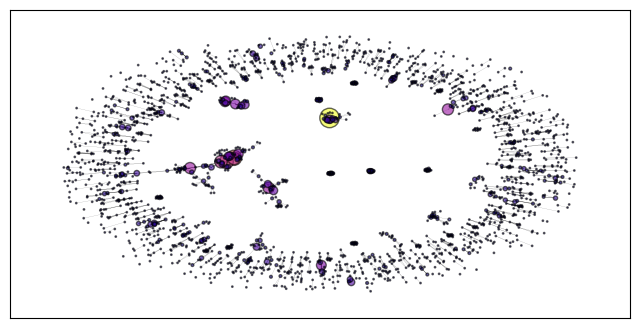

In [39]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Example adjacency matrix
adj_matrix = copy.deepcopy(co_authorship)

# Create a graph
G = nx.Graph()

to_remove = []
for i in range(adj_matrix.shape[0]):
    if adj_matrix[i, i] < 1:
        to_remove.append(i)
adj_matrix = np.delete(adj_matrix, to_remove, axis=0)
adj_matrix = np.delete(adj_matrix, to_remove, axis=1)

# Add nodes with weights from the diagonal
for i in range(adj_matrix.shape[0]):
    G.add_node(i, weight=adj_matrix[i, i])

# Add edges with weights from non-diagonal elements
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if i != j and adj_matrix[i, j] > 0:  # Exclude diagonal and zero weights
            G.add_edge(i, j, weight=adj_matrix[i, j])

# Calculate node sizes and edge widths based on weights
node_sizes = [pow(G.nodes[node]['weight']*1,2) for node in G.nodes]  # Scale node sizes
# Normalize node weights to be in range [0, 1] for color mapping
norm = plt.Normalize(min(node_sizes), max(node_sizes))
cmap = cm.plasma  # Choose a colormap (you can change this)
# Map the normalized weights to colors
node_colors = [cmap(norm(weight)) for weight in node_sizes]

edge_widths = [max(pow(G[u][v]['weight'],2), 0) for u, v in G.edges]  # Use edge weights directly
edge_widths = [(ew/max(edge_widths))*3 for ew in edge_widths]
edge_norm = plt.Normalize(min(edge_widths), max(edge_widths))
edge_cmap = cm.gray  # Use the gray colormap (light gray for small weights, black for large weights)

# Map the normalized edge weights to colors
edge_colors = [edge_cmap(edge_norm(weight)) for weight in edge_widths]

# Draw the graph
pos = nx.spring_layout(G, k=0.05, seed=42)

# Draw nodes with sizes proportional to weights
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.6, edgecolors="black")

# Draw edges with widths proportional to weights
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)

plt.savefig('coauthors.pdf', bbox_inches='tight')

# Display the graph
plt.show()

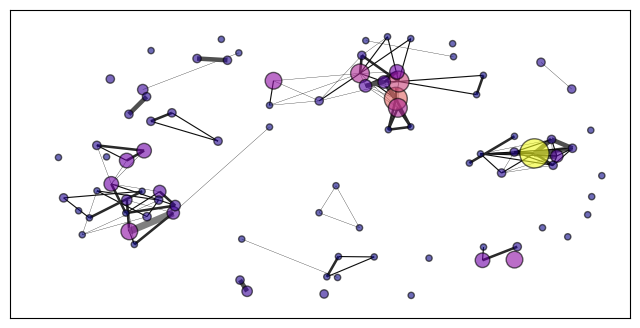

In [40]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Example adjacency matrix
adj_matrix = copy.deepcopy(co_authorship)

# Create a graph
G = nx.Graph()

to_remove = []
for i in range(adj_matrix.shape[0]):
    if adj_matrix[i, i] < 3:
        to_remove.append(i)
adj_matrix = np.delete(adj_matrix, to_remove, axis=0)
adj_matrix = np.delete(adj_matrix, to_remove, axis=1)


# Add nodes with weights from the diagonal
for i in range(adj_matrix.shape[0]):
    G.add_node(i, weight=adj_matrix[i, i])

# Add edges with weights from non-diagonal elements
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if i != j and adj_matrix[i, j] > 0:  # Exclude diagonal and zero weights
            G.add_edge(i, j, weight=adj_matrix[i, j])

# Calculate node sizes and edge widths based on weights
node_sizes = [pow(G.nodes[node]['weight']*1.5,2) for node in G.nodes]  # Scale node sizes
# Normalize node weights to be in range [0, 1] for color mapping
norm = plt.Normalize(min(node_sizes), max(node_sizes))
cmap = cm.plasma  # Choose a colormap (you can change this)
# Map the normalized weights to colors
node_colors = [cmap(norm(weight)) for weight in node_sizes]

edge_widths = [max(pow(G[u][v]['weight'],2), 0.1) for u, v in G.edges]  # Use edge weights directly
edge_widths = [(ew/max(edge_widths))*10 for ew in edge_widths]
edge_norm = plt.Normalize(min(edge_widths), max(edge_widths))
edge_cmap = cm.gray  # Use the gray colormap (light gray for small weights, black for large weights)

# Map the normalized edge weights to colors
edge_colors = [edge_cmap(edge_norm(weight)) for weight in edge_widths]

# Draw the graph
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes with sizes proportional to weights
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.6, edgecolors="black")

# Draw edges with widths proportional to weights
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)

plt.savefig('coauthors-cleaned.pdf', bbox_inches='tight')

# Display the graph
plt.show()

# Number of Publications and h-index per author

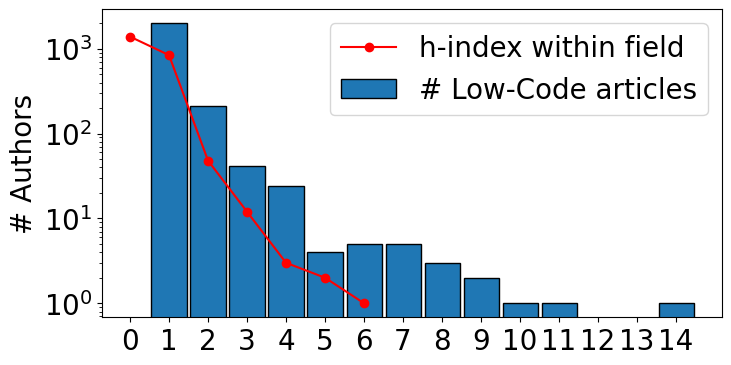

In [41]:
import matplotlib.pyplot as plt

data = {}

for a in authors_lowcode:
    index = authors_lowcode[a]
    if index in data:
        data[index] += 1
    else:
        data[index] = 1
        
# Prepare data for the histogram
values = list(data.keys())  # Keys represent the data values
frequencies = list(data.values())  # Values represent the frequencies

h_index = {}

for a in authors_citations_lowcode:
    h = authors_citations_lowcode[a][1]
    if h in h_index:
        h_index[h] += 1
    else:
        h_index[h] = 1
        
# Prepare data for the histogram
line_values = list(h_index.keys())  # Keys represent the data values
line_frequencies = list(h_index.values())  # Values represent the frequencies

# Plot the histogram
plt.bar(values, frequencies, width=0.9, edgecolor='black', label='# Low-Code articles')  # Bar plot for discrete bins

# Plot the histogram
plt.plot(line_values, line_frequencies, marker='o', color='red', label='h-index within field')  # Bar plot for discrete bins

plt.yscale('log')

# Ensure x-axis labels are integers
plt.xticks(range(0, max(values) + 1))  # Set ticks from min to max value

# Add labels and title
#plt.xlabel('# Low-Code articles')
plt.ylabel('# Authors')
plt.legend()

plt.savefig('lowcode_authors.pdf', bbox_inches='tight')

plt.show()
